Итоговый проект

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import dateutil.relativedelta

import scipy.stats as sts
import scipy.stats.mstats as mstats
from scipy.stats import pearsonr

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from scipy.stats import ttest_ind

1) Загрузить файл data_breast.csv. В данном файле собрана расчетная информация с обработанных изображений биоптата молочных желез женщин. Задача заключается в предсказании переменной “Diagnosis” - является ли содержимое биоптата доброкачественным (значение “B” – benign) либо злокачественным (значение “M” –malicious). Описание данных доступно на сайте

In [2]:
data = pd.read_csv('data_breast.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
#Переменную 'diagnosis' переведем в бинарный признак, доброкачественная - 0, злокачественная - 1
data['diagnosis'] = data['diagnosis'].apply(lambda x: 1 if x=='M' else 0)

In [4]:
# смысла в столбце id и Unnamed: 32 нет - удаляю
data = data.drop(['id'], axis=1, inplace=False)
data = data.drop(['Unnamed: 32'], axis=1, inplace=False)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null int64
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave points_se          569 no

Как видим, пропущенных значений нет.

2)Рассчитать основные статистики для переменных (среднее, медиана, мода, мин/макс, сред. отклонение).

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
diagnosis,569.0,0.372583,0.483918,0.000000,0.000000,0.000000,1.000000,1.00000
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400


In [7]:
#и мода
data.mode().head(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.0,12.34,14.93,82.61,512.2,0.1007,0.1147,0.0,0.0,0.1601,...,12.36,17.70,101.7,284.4,0.1216,0.1486,0.0,0.0,0.2226,0.07427
1,NaN,NaN,15.70,87.76,NaN,NaN,0.1206,NaN,NaN,0.1714,...,NaN,27.26,105.9,402.8,0.1223,0.3416,NaN,NaN,0.2369,NaN
2,NaN,NaN,16.84,134.70,NaN,NaN,NaN,NaN,NaN,0.1717,...,NaN,NaN,117.7,439.6,0.1234,NaN,NaN,NaN,0.2383,NaN
3,NaN,NaN,16.85,NaN,NaN,NaN,NaN,NaN,NaN,0.1769,...,NaN,NaN,NaN,458.0,0.1256,NaN,NaN,NaN,0.2972,NaN
4,NaN,NaN,17.46,NaN,NaN,NaN,NaN,NaN,NaN,0.1893,...,NaN,NaN,NaN,472.4,0.1275,NaN,NaN,NaN,0.3109,NaN
5,NaN,NaN,18.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,489.5,0.1312,NaN,NaN,NaN,0.3196,NaN
6,NaN,NaN,18.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,546.7,0.1347,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,19.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,547.4,0.1401,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,20.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,624.1,0.1415,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,698.8,NaN,NaN,NaN,NaN,NaN,NaN


4)Рассчитать и визуализировать корреляционную матрицу для переменных.

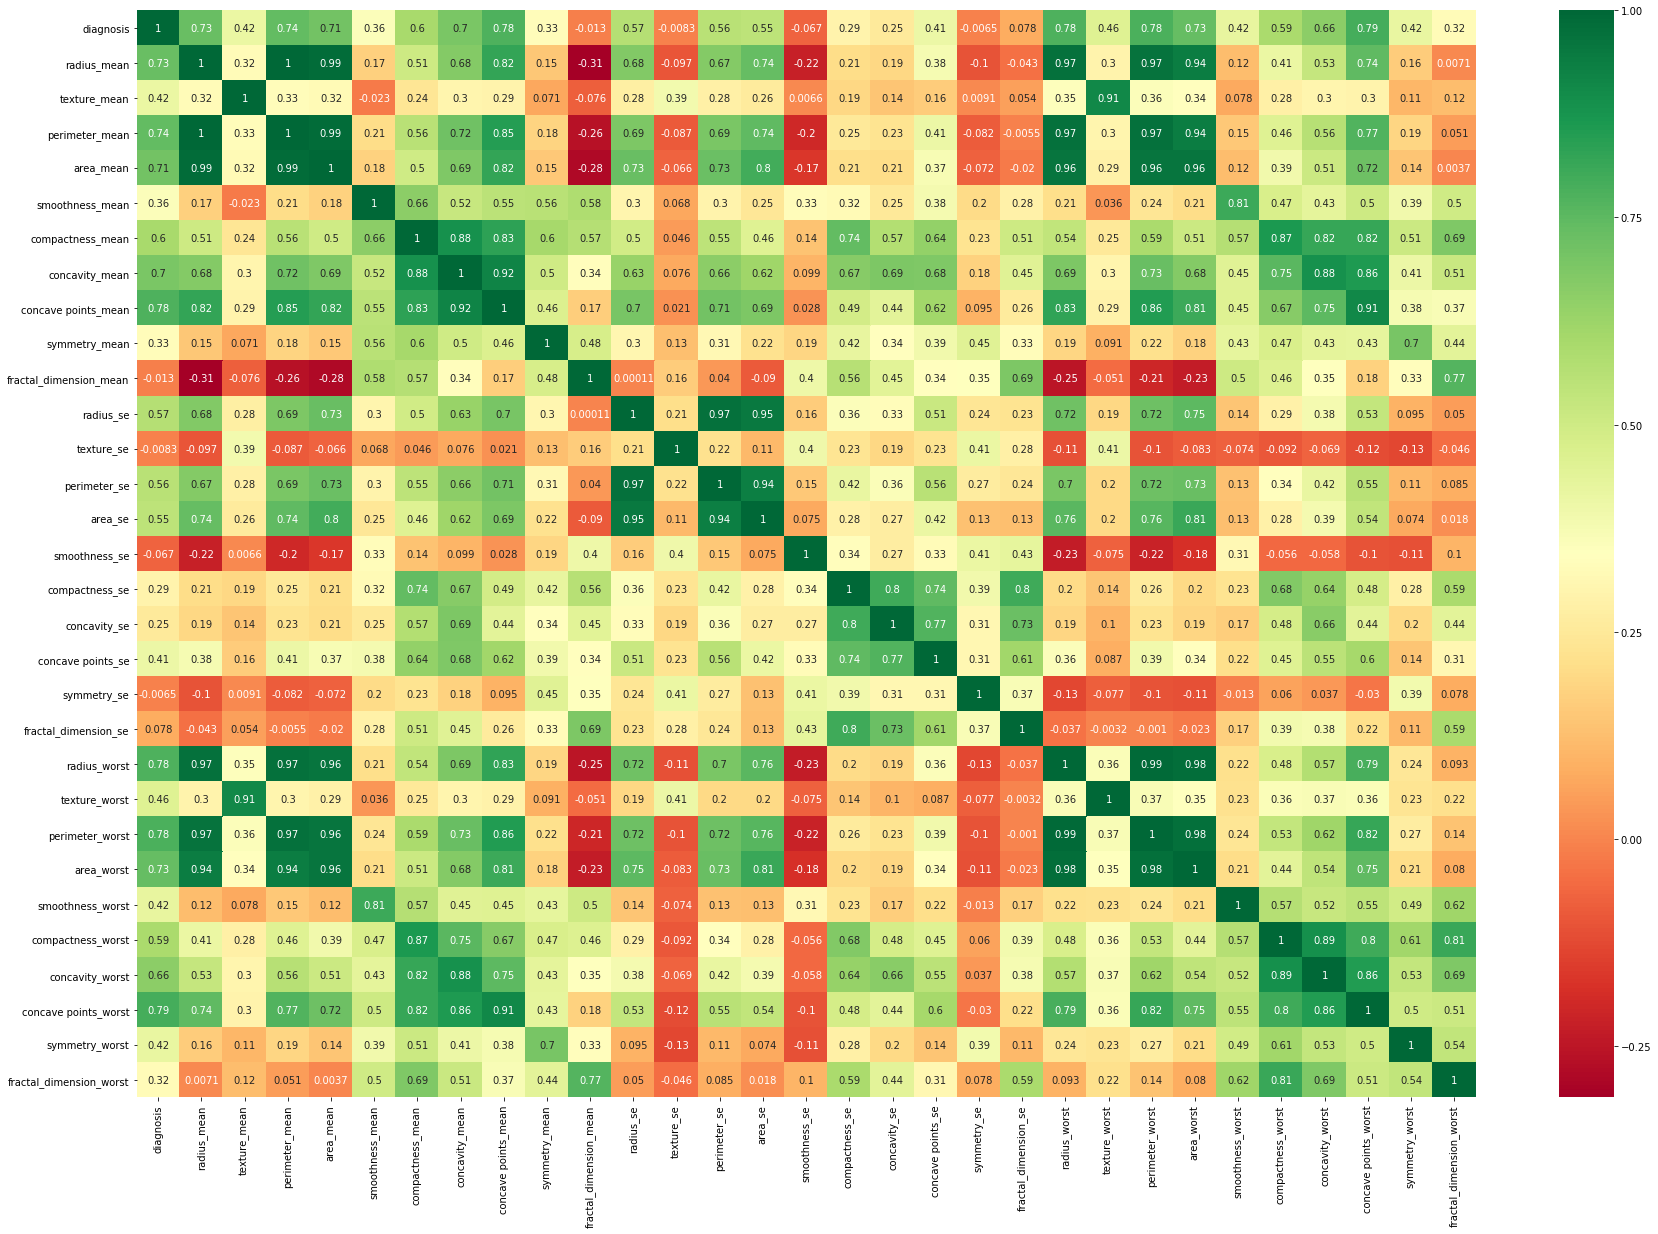

In [8]:
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(data.corr(),annot=True,cmap="RdYlGn");

5.Визуализировать взаимосвязи между переменными (scatter plots, гистограммы, …).

/home/anastacia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/anastacia/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/anastacia/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/anastacia/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, *

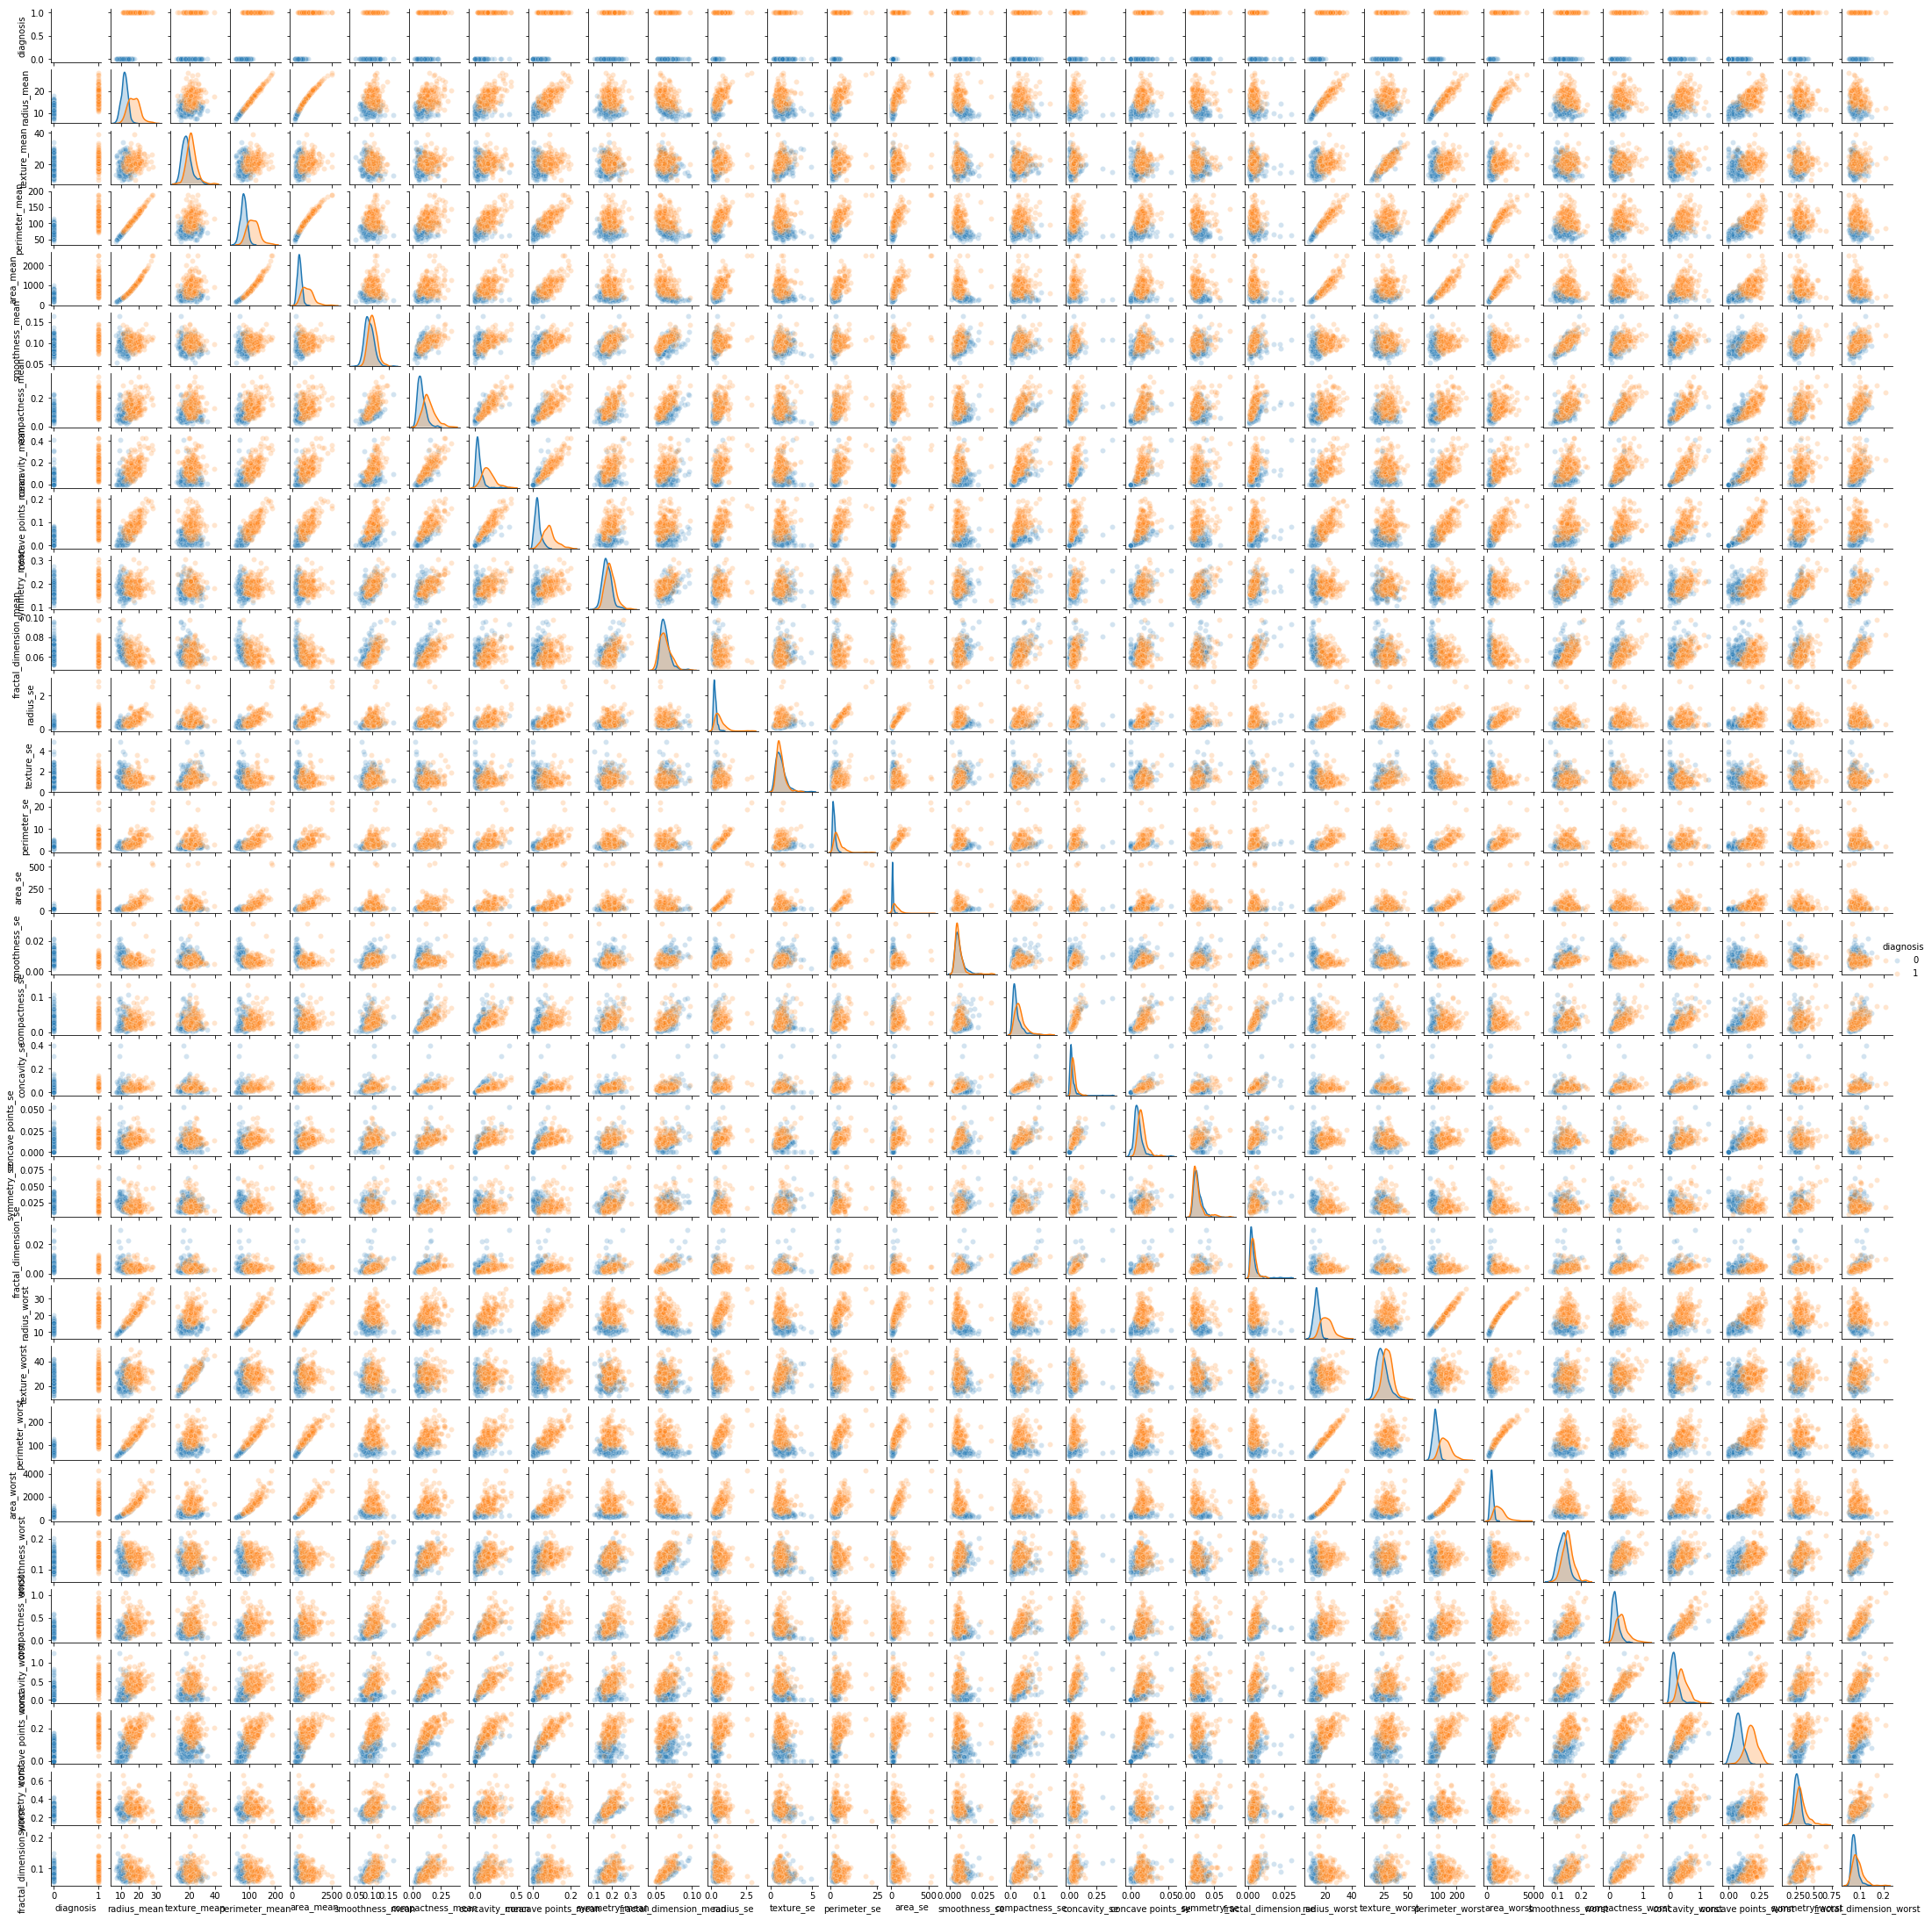

In [9]:
g=sns.pairplot(data=data,plot_kws={'alpha':0.2},hue='diagnosis');
g.fig.set_size_inches(30,30)

In [10]:
# Отнормируем числовые переменные датасета с очевидно сильной корреляцией
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
np_scaled = min_max_scaler.fit_transform(data[['concave points_worst','symmetry_se']])
data_norm = pd.concat([pd.DataFrame(np_scaled, columns=['concave points_worst','symmetry_se']),data[['diagnosis']]], axis = 1)
data_bad = data_norm[data_norm['diagnosis']==1]
data_not_bad = data_norm[data_norm['diagnosis']==0]

6)С помощью статистических методов проверить взаимосвязи между переменными.

In [17]:
#Проверим гипотезу о различии среднего количества вогнутых участков контура между злокачественными и доброкачественными опухолями
ttest_ind(data_bad['concave points_worst'], data_not_bad['concave points_worst'])

Ttest_indResult(statistic=31.054555115984236, pvalue=1.9690997072164375e-124)

p-value меньше уровня значимости, а значит, что можно отвергнуть нулевую гипотезу об одинаковых средних, т.е. средний уровень количества вогнутых участков контура между злокачественными и доброкачественными опухолями отличается.

In [19]:
#Проверим гипотезу о различии среднего значения симметричности между злокачественными и доброкачественными опухолями
ttest_ind(data_bad['symmetry_se'], data_not_bad['symmetry_se'])

Ttest_indResult(statistic=-0.15529780000593163, pvalue=0.8766418183858853)

p-value больше уровня значимости, а это означает, что мы нельзя отвергнуть нулевую гипотезу об одинаковых средних, т.е. средние значения симметричности между злокачественными и доброкачественными опухолями статистически не отличаются.

7) Выбрать стратегию Feature Selection – сокращение размерности либо генерация новых переменных. Какой из этих двух подходов даст лучший результат при классификации?

In [25]:
C_RANDOM_STATE = 7

In [21]:
X, y = data.drop(['diagnosis'], axis=1,inplace=False), data['diagnosis'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20)

In [22]:
X_train.shape, X_test.shape, len(y_train), len(y_test)

((455, 30), (114, 30), 455, 114)

In [23]:
#Линейная регрессия
lm = LogisticRegression().fit(X_train,y_train)
y_train_predict = lm.predict(X_train)
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

y_test_predict = lm.predict(X_test)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

print(f'accuracy: {accuracy_score(y_test, y_test_predict)}')
print(f'f1: {f1_score(y_test, y_test_predict, average="macro")}')
print(f'precision: {precision_score(y_test, y_test_predict, average="macro")}')
print(f'recall: {recall_score(y_test, y_test_predict, average="macro")}')

Train:  0.95
Test:  0.96
accuracy: 0.9649122807017544
f1: 0.9623015873015872
precision: 0.9623015873015872
recall: 0.9623015873015872


/home/anastacia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
#случайный лес
clf = RandomForestClassifier(n_estimators=100, random_state=C_RANDOM_STATE).fit(X_train, y_train)
y_train_predict = clf.predict_proba(X_train)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

y_test_predict = clf.predict_proba(X_test)[:, 1]
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)
print(f'accuracy: {accuracy_score(y_test, y_test_predict)}')
print(f'f1: {f1_score(y_test, y_test_predict, average="macro")}')
print(f'precision: {precision_score(y_test, y_test_predict, average="macro")}')
print(f'recall: {recall_score(y_test, y_test_predict, average="macro")}')

Train:  1.0
Test:  1.0
accuracy: 0.9912280701754386
f1: 0.99062114356232
precision: 0.9883720930232558
recall: 0.9930555555555556


Вывод: случайный лес даст лучший результат при классификации.

8) Рассчитать Feature Selection для выбранных переменных.
9) Решить задачу бинарной классификации и предсказать переменную ”Diagnosis ” протестировав как минимум 2 алгоритма. Использовать те алгоритмы, которые позволяют предсказать вероятность класса (proba). Рассчитать и вывести вероятность каждого класса.


In [54]:
#Найдем наилучшие гиперпараметры для случайного леса для тренировочного набора
random_grid = {'n_estimators': [100]}
l_result = []
for n in range(1,data.shape[1]-1):
    pca = PCA(n_components=n, random_state=C_RANDOM_STATE)
    pc = pca.fit_transform(data.drop(['diagnosis'], axis=1,inplace=False))
    data_pc = pd.DataFrame(data = pc, columns = ['pc'+str(i) for i in range(n)])
    data_with_pc = pd.concat([data_pc, data[['diagnosis']]], axis = 1)
    
    X, y = data_with_pc.drop(['diagnosis'], axis=1,inplace=False), data_with_pc['diagnosis'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
    
    clf = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=C_RANDOM_STATE), n_iter = 1, cv = 10, param_distributions=random_grid , verbose=2, random_state=C_RANDOM_STATE, n_jobs = -1).fit(X_train, y_train)
    y_test_predict_proba = clf.predict_proba(X_test)[:, 1]
    y_test_predict = clf.predict(X_test)
    l_result.append((n,np.round(roc_auc_score(y_test, y_test_predict_proba), 2),accuracy_score(y_test, y_test_predict),f1_score(y_test, y_test_predict, average="macro")))


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished
/home/anastacia/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
/home/anastacia/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
/home/anastacia/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
/home/anastacia/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
/home/anastacia/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
/home/anastacia/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
/home/anastacia/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
/home/anastacia/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
/home/anastacia/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished


In [60]:
#сортировка по наивысшему ROC_AUC на тесте и F-мере
l_result.sort(key=lambda x:x[1]*10+x[3],reverse=True)
l_result

[(18, 1.0, 0.9790209790209791, 0.9774269928966061),
 (27, 1.0, 0.965034965034965, 0.9623783214943435),
 (9, 1.0, 0.958041958041958, 0.9553682896379526),
 (22, 1.0, 0.958041958041958, 0.9553682896379526),
 (14, 1.0, 0.951048951048951, 0.9481158969574457),
 (20, 0.99, 0.9790209790209791, 0.9774269928966061),
 (29, 0.99, 0.965034965034965, 0.9626690335717641),
 (16, 0.99, 0.965034965034965, 0.9620669531540135),
 (28, 0.99, 0.958041958041958, 0.9550314465408805),
 (21, 0.99, 0.951048951048951, 0.947329650092081),
 (10, 0.99, 0.9440559440559441, 0.9409090909090909),
 (12, 0.99, 0.9370629370629371, 0.9311212202301312),
 (7, 0.98, 0.958041958041958, 0.9538709677419355),
 (8, 0.98, 0.951048951048951, 0.94773664700047),
 (11, 0.98, 0.951048951048951, 0.94773664700047),
 (24, 0.98, 0.951048951048951, 0.94773664700047),
 (4, 0.98, 0.951048951048951, 0.9468937344156189),
 (6, 0.98, 0.951048951048951, 0.9468937344156189),
 (19, 0.98, 0.9440559440559441, 0.9404910528506034),
 (23, 0.98, 0.9440559440

In [62]:
#Лучшее количество компонент

print({l_result[0][0]})

{18}


In [47]:
n=l_result[0][0]
pca = PCA(n_components=n, random_state=C_RANDOM_STATE)
pc = pca.fit_transform(data.drop(['diagnosis'], axis=1,inplace=False))
df_pc = pd.DataFrame(data = pc, columns = ['pc'+str(i) for i in range(n)])
df_with_pc = pd.concat([data_pc, data[['diagnosis']]], axis = 1)

X, y = data_with_pc.drop(['diagnosis'], axis=1,inplace=False), data_with_pc['diagnosis'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

In [48]:
parameters = {
    'n_estimators'      : [50,100,200,300,500],
    'max_depth'         : [10, 15, 20, 25, 30],
    'min_samples_split' : [2,10,100]
}

gscv = GridSearchCV(RandomForestClassifier(random_state=C_RANDOM_STATE), parameters, cv=10, n_jobs=-1)
gscv.fit(X_train, y_train)

print(gscv.score(X_test, y_test))
print(gscv.best_params_)

0.916083916083916
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}


10) Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall

Test ROC_AUC:  0.97
Test accuracy: 0.916083916083916
Test f1: 0.9093406593406592
Test precision: 0.9129369138959932
Test recall: 0.9061844863731656


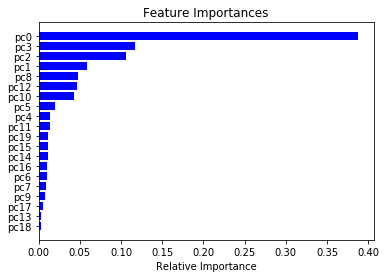

In [49]:
cv_best_params = gscv.best_params_
clf = RandomForestClassifier(n_estimators=cv_best_params['n_estimators'],max_depth=cv_best_params['max_depth'],min_samples_split=cv_best_params['min_samples_split'],
                             random_state=C_RANDOM_STATE, n_jobs=-1).fit(X_train, y_train)
y_test_predict = clf.predict_proba(X_test)[:, 1]
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test ROC_AUC: ", roc_auc_test)
y_test_predict = clf.predict(X_test)
print(f'Test accuracy: {accuracy_score(y_test, y_test_predict)}')
print(f'Test f1: {f1_score(y_test, y_test_predict, average="macro")}')
print(f'Test precision: {precision_score(y_test, y_test_predict, average="macro")}')
print(f'Test recall: {recall_score(y_test, y_test_predict, average="macro")}')

features = X_train.columns
importances = clf.feature_importances_[0:20]

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()